In [109]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()

print(bucket)

sagemaker-us-east-1-011113936377


In [110]:
!aws s3 sync s3://{bucket}/wsb/data/ data/

In [111]:
import sys
import re
import os
import json
import datetime
import pytz
import numpy as np


In [112]:
ET = pytz.timezone('US/Eastern')

ignorelist=["DD","FREE","CASH","ON","I"]
allsymbols=[]
with open("allsymbols.txt") as fh:
    allsymbols=fh.readlines()
allsymbols = [x.strip() for x in allsymbols]

dt=datetime.timedelta(days=7)


In [113]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [114]:
import datetime

stockdata={}
def getstockprice(symbol,date):
    if symbol not in stockdata:
        with open("stockprices/"+symbol,"r") as fh:
            data=json.load(fh)
        stockdata[symbol]={}
        for stockday in data:
            indate=datetime.datetime.strptime(stockday["begins_at"],"%Y-%m-%dT%H:%M:%SZ").date()
            stockdata[symbol][indate]=stockday
    today=datetime.date.today()
    while True:
        #print(date)
        if date in stockdata[symbol]:
            return float(stockdata[symbol][date]['close_price'])
        date=date+datetime.timedelta(days=1)
        if date>today:
            break
    raise Exception("No stock data found")
    return None
            

In [115]:
files = os.listdir("data/")

foundsymbols=[]
relevant_posts = []
i=0
for file in files:
  if(round(i/100,0)==i/100):
        update_progress(i / len(files))  
  with open("data/"+file,"r") as fh:
    try:
        data=json.load(fh)
        text = (data["title"]+" "+data["selftext"]).replace('\"','').replace('\'','')
        allmatches=[]
        matches=re.findall('\W*([A-Z][A-Z\.]{0,3})\W',text)
        for submatch in matches:
            allmatches.append({submatch:submatch})
            #pass
        matches2=re.findall('\W*(\$[a-z\.]{1,4})',text)
        for submatch in matches2:
            allmatches.append({submatch.upper()[1:]:submatch})
        thesesymbols=[]
        #print(allmatches)
        for submatch in allmatches:
            symbol=list(submatch.keys())[0]
            #print(submatch.keys())
            #print(symbol)
            #print([list(x.keys())[0] for x in thesesymbols])
            if symbol in allsymbols and symbol not in [list(x.keys())[0] for x in thesesymbols] and symbol not in ignorelist:
                thesesymbols.append(submatch)
                if symbol not in foundsymbols:
                    foundsymbols.append(symbol)
        if len(thesesymbols)>0:
            relevant_posts.append({"data":data,"symbols":thesesymbols})
            #print(thesesymbols)
    except Exception as err:
      print("Error with",file)
      raise(err)
  i+=1
    

  #if i>1000:
  #  break



Progress: [####################] 99.9%


In [116]:
print(len(foundsymbols))
with open("foundsymbols.txt","w") as fh:
    fh.write("\n".join(foundsymbols))
foundsymbols

3661


['TSLA',
 'B',
 'AMZN',
 'COST',
 'C',
 'LULU',
 'AMD',
 'FB',
 'PTON',
 'AAPL',
 'GOLD',
 'ROKU',
 'NFLX',
 'DIS',
 'HAS',
 'GOOD',
 'ONCY',
 'SPCE',
 'AMC',
 'KR',
 'PM',
 'ABC',
 'X',
 'Y',
 'CYBR',
 'PANW',
 'RPD',
 'EDIT',
 'DTE',
 'DCOM',
 'AT',
 'ACB',
 'THC',
 'MU',
 'IP',
 'AG',
 'GILD',
 'TJX',
 'HTZ',
 'TVTY',
 'DGX',
 'QQQ',
 'TA',
 'BYND',
 'POST',
 'SR',
 'NIO',
 'RING',
 'A',
 'NEW',
 'IT',
 'FOSL',
 'BK',
 'PINS',
 'KRTX',
 'OVID',
 'DOW',
 'SBUX',
 'VC',
 'MCD',
 'MSFT',
 'WMT',
 'SNAP',
 'PECK',
 'HUGE',
 'GDP',
 'WELL',
 'CDC',
 'BA',
 'V',
 'FAT',
 'NOC',
 'LMT',
 'RH',
 'AAL',
 'GO',
 'SDC',
 'ALGN',
 'ONE',
 'ATVI',
 'M',
 'CEO',
 'K',
 'ALLY',
 'SIX',
 'CME',
 'AM',
 'LIVE',
 'FIT',
 'SWBI',
 'EC',
 'F',
 'CRM',
 'BAC',
 'CTO',
 'PEP',
 'UAL',
 'DAL',
 'JNJ',
 'PCG',
 'E',
 'PLUS',
 'AMTD',
 'TTD',
 'DEA',
 'CBD',
 'CCL',
 'ARE',
 'OUT',
 'G',
 'BMO',
 'IONS',
 'FOR',
 'HAL',
 'INFY',
 'KO',
 'SYF',
 'NDAQ',
 'NEE',
 'ERIC',
 'DPZ',
 'LUV',
 'UNP',
 'AXP',
 'SNY'

In [117]:
#split into multiple corpus here

import random
random.shuffle(relevant_posts)
#relevant_posts = relevant_posts[0:int(.2*len(relevant_posts))]

n_train = int(0.8 * len(relevant_posts))

training_posts = relevant_posts[:n_train]
test_posts = relevant_posts[n_train:]
val_posts = test_posts[:n_train//2]
test_posts = test_posts[n_train//2:]

vocab_input = [t["data"]["title"]+" "+t["data"]["selftext"] for t in training_posts]
print(len(relevant_posts),n_train)

34504 27603


In [118]:
test_posts = relevant_posts[n_train:]
print(n_train,n_train//2)
test_posts = relevant_posts[n_train:]
print(len(test_posts))
print(len(test_posts)//2)
val_posts = test_posts[:len(test_posts)//2]
test_posts = test_posts[len(test_posts)//2:]
len(test_posts)

27603 13801
6901
3450


3451

In [119]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [120]:
threshhold=.05

def calculateData(post):
    #print(post)
    data=post["data"]
    thesesymbols=post["symbols"]
    text = nltk.word_tokenize((data["title"]+" "+data["selftext"]).lower())
    returnarray=[]
    for symbolmap in thesesymbols:
        symbol=list(symbolmap.keys())[0]
        try:
            start=ET.localize(datetime.datetime.fromtimestamp(data["created_utc"]))
            if start.hour>=9:
                start=start+datetime.timedelta(days=1)
            start=start.replace(hour=9,minute=0,second=0,microsecond=0).date()
            end=start+dt
            startprice=getstockprice(symbol,start)
            endprice=getstockprice(symbol,end)
            #print(start,end,history)
            delta=(endprice-startprice)/startprice
            if delta<=-1*(threshhold):
                result=1
            elif delta>=threshhold:
                result=2
            else:
                result=0
            returnarray.append("__label__"+str(result)+" "+' '.join(text))
        except Exception as err:
            print("Error with",symbol,", skipping this one:",err)
    return returnarray


def assembleData(posts):
    data = ""
    i=0
    for post in posts:
        #try:
        if True:
           response=calculateData(post)
           for row in response:
                data += row+"\n"
        #except Exception as err:
        #    print("Error",err)
        #    pass
        i+=1
        if(round(i/100,0)==i/100):
            update_progress(i / len(posts))
    return data

training_data = assembleData(training_posts)
test_data = assembleData(test_posts)
val_data = assembleData(val_posts)

Progress: [####################] 98.6%


In [121]:
#import pandas as pd
#pd.DataFrame(training_data, columns=["Training set"])

In [122]:
print(training_data[:1000])

__label__0 insider trading megathread i was captured by the bloomberg empire and interrogated for weeks in the dungeons of michael bloomberg 's secret headquarters : the morning star . the methods they used to get me to disclose the information i stole were ... severe . my butthole will never be the same . alas , i held out without telling them anything . i was convinced all hope was lost and was attempting to drown myself in my own piss when my cell door opened . `` are n't you a little retarded to be a bloomberg trooper ? '' i asked the man standing there . when he took off his mask i gasped in shock . `` i 'm from r/wallstreetbets i 'm here to rescue you , '' he said . `` you 're what ? '' `` i 'm here to rescue you . i 've got your robinhood app . i 'm here with u/1r0nyman ! '' `` u/1r0nyman ? where is he ! does he have tendies ? '' i replied , ecstatic . `` c'mon ! '' the man yelled as we ran out the door and into the hallway . suddenly , we were ambushed by a squad of bloomberg t

In [123]:
%%time

import boto3
prefix='wsb-blazingtext'
region = boto3.Session().region_name
s3=boto3.client('s3')

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

s3.put_object(Bucket=bucket,Key=train_channel,Body=training_data)
s3.put_object(Bucket=bucket,Key=validation_channel,Body=val_data)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)


CPU times: user 2.14 s, sys: 706 ms, total: 2.84 s
Wall time: 6.02 s


In [124]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [125]:
val_data.count("\n")

8507

In [126]:
region_name = boto3.Session().region_name
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


In [128]:
role = sagemaker.get_execution_role()

bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.10xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=session)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [129]:


bt_model.set_hyperparameters(mode="supervised",
                            epochs=10,
                            min_count=2,
                            learning_rate=0.05,
                            vector_dim=10,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5,
                            word_ngrams=2)



In [130]:
train_data_input = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
validation_data_input = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data_input, 'validation': validation_data_input}

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [131]:
%%time

bt_model.fit(inputs=data_channels, logs=True)

2020-08-11 13:21:33 Starting - Starting the training job...
2020-08-11 13:21:35 Starting - Launching requested ML instances......
2020-08-11 13:22:52 Starting - Preparing the instances for training......
2020-08-11 13:23:48 Downloading - Downloading input data...
2020-08-11 13:24:24 Training - Downloading the training image...
2020-08-11 13:24:39 Training - Training image download completed. Training in progress.Arguments: train
[08/11/2020 13:24:40 WARNING 140259641399104] Loggers have already been setup.
[08/11/2020 13:24:40 WARNING 140259641399104] Loggers have already been setup.
[08/11/2020 13:24:40 INFO 140259641399104] nvidia-smi took: 0.0251820087433 secs to identify 0 gpus
[08/11/2020 13:24:40 INFO 140259641399104] Running single machine CPU BlazingText training using supervised mode.
[08/11/2020 13:24:40 INFO 140259641399104] Processing /opt/ml/input/data/train/train . File size: 386 MB
[08/11/2020 13:24:40 INFO 140259641399104] Processing /opt/ml/input/data/validation/valida

In [132]:
text_classifier = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [133]:
labels=[]
sentence_list=[]
for line in test_data.split("\n"):
    try:
        (label,sentence) = line.split(" ",1)
        labels.append(label)
        sentence_list.append(sentence)
    except:
        pass

print(len(labels),len(sentence_list))

7763 7763


In [134]:
payload = {"instances" : sentence_list[:10],
           "configuration": {"k": 1}}
response = text_classifier.predict(json.dumps(payload))
print(response)
print(len(json.loads(response)))

b'[{"prob": [0.4869362413883209], "label": ["__label__0"]}, {"prob": [0.6166167855262756], "label": ["__label__0"]}, {"prob": [0.3796028792858124], "label": ["__label__1"]}, {"prob": [0.3796028792858124], "label": ["__label__1"]}, {"prob": [0.8914448022842407], "label": ["__label__0"]}, {"prob": [0.5491712093353271], "label": ["__label__1"]}, {"prob": [0.5491712093353271], "label": ["__label__1"]}, {"prob": [0.5327793955802917], "label": ["__label__0"]}, {"prob": [0.6783377528190613], "label": ["__label__0"]}, {"prob": [0.7064494490623474], "label": ["__label__1"]}]'
10


In [135]:
chunksize=300
i=0
predictions=[]
while i<len(sentence_list):
    chunkend=i+chunksize
    if chunkend>len(sentence_list):
        chunkend=len(sentence_list)
    #print(i,chunkend)
    payload = {"instances" : sentence_list[i:chunkend],
              "configuration": {"k": 1}}
    response = text_classifier.predict(json.dumps(payload))
    print(i/len(sentence_list)*100)
    #print(len(json.loads(response)))
    predictions.extend(json.loads(response))
    i+=chunksize
    
print(json.dumps(preds, indent=2))

0.0
3.864485379363648
7.728970758727296
11.593456138090945
15.457941517454593
19.32242689681824
23.18691227618189
27.051397655545532
30.915883034909186
34.780368414272836
38.64485379363648
42.50933917300013
46.37382455236378
50.23830993172742
54.102795311091064
57.96728069045473
61.83176606981837
65.69625144918201
69.56073682854567
73.42522220790931
77.28970758727296
81.1541929666366
85.01867834600026
88.8831637253639
92.74764910472756
96.6121344840912
[
  "__label__1",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__1",
  "__label__1",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__1",
  "__label__1",
  "__label__0",
  "__label__0",
  "__label__1",
  "__label__1",
  "__label__0",
  "__label__0",
  "__label__0",
  "__label__1",
  "__label__2",
  "__label__1

In [136]:
print(len(labels),len(predictions))

7763 7763


In [137]:
preds=[]
for row in predictions:
    preds.append(row["label"][0])

In [138]:
preds[0:10]

['__label__0',
 '__label__0',
 '__label__1',
 '__label__1',
 '__label__0',
 '__label__1',
 '__label__1',
 '__label__0',
 '__label__0',
 '__label__1']

In [139]:
labels[0:10]

['__label__2',
 '__label__0',
 '__label__0',
 '__label__0',
 '__label__0',
 '__label__2',
 '__label__1',
 '__label__2',
 '__label__0',
 '__label__0']

In [140]:
import numpy
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = numpy.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = numpy.zeros([3,3], numpy.int32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[int(predicted[-1:]), int(actual[-1:])] += 1
    
    return error, confusions

Test error: 42.2%


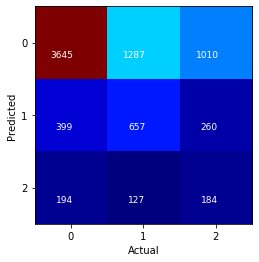

In [141]:
import matplotlib.pyplot as plt
%matplotlib inline  

NUM_LABELS = 3  # change it according to num_class in your dataset
test_error, confusions = error_rate(numpy.asarray(preds), numpy.asarray(labels))
print('Test error: %.1f%%' % test_error)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

In [142]:
session.delete_endpoint(text_classifier.endpoint)

In [143]:
import sklearn
print(sklearn.metrics.classification_report(numpy.asarray(labels),numpy.asarray(preds)))

              precision    recall  f1-score   support

  __label__0       0.61      0.86      0.72      4238
  __label__1       0.50      0.32      0.39      2071
  __label__2       0.36      0.13      0.19      1454

    accuracy                           0.58      7763
   macro avg       0.49      0.43      0.43      7763
weighted avg       0.54      0.58      0.53      7763

